In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("loan_approval.csv")
df.shape

(2000, 8)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            2000 non-null   object 
 1   city            2000 non-null   object 
 2   income          2000 non-null   int64  
 3   credit_score    2000 non-null   int64  
 4   loan_amount     2000 non-null   int64  
 5   years_employed  2000 non-null   int64  
 6   points          2000 non-null   float64
 7   loan_approved   2000 non-null   bool   
dtypes: bool(1), float64(1), int64(4), object(2)
memory usage: 111.5+ KB


In [4]:
df.head()

,name,city,income,credit_score,loan_amount,years_employed,points,loan_approved
0,Allison Hill,East Jill,113810,389,39698,27,50.0,False
1,Brandon Hall,New Jamesside,44592,729,15446,28,55.0,False
2,Rhonda Smith,Lake Roberto,33278,584,11189,13,45.0,False
3,Gabrielle Davis,West Melanieview,127196,344,48823,29,50.0,False
4,Valerie Gray,Mariastad,66048,496,47174,4,25.0,False


In [5]:
# checking for class balance in dataset 
df.loan_approved.value_counts()

loan_approved
False    1121
True      879
Name: count, dtype: int64

In [6]:
# confirm that name and city variables are redundant 

print("count of unique names:", df.name.nunique())
print("count of unique cities:", df.city.nunique())

# just checking in case few cities have disproportionately high no. of approvals or rejections 
print("count of unique cities in case of loan approval:", df[df.loan_approved == True]["city"].nunique())
print("count of unique cities in case of loan rejections:", df[df.loan_approved == False]["city"].nunique())

count of unique names: 2000
count of unique cities: 1882
count of unique cities in case of loan approval: 851
count of unique cities in case of loan rejections: 1087


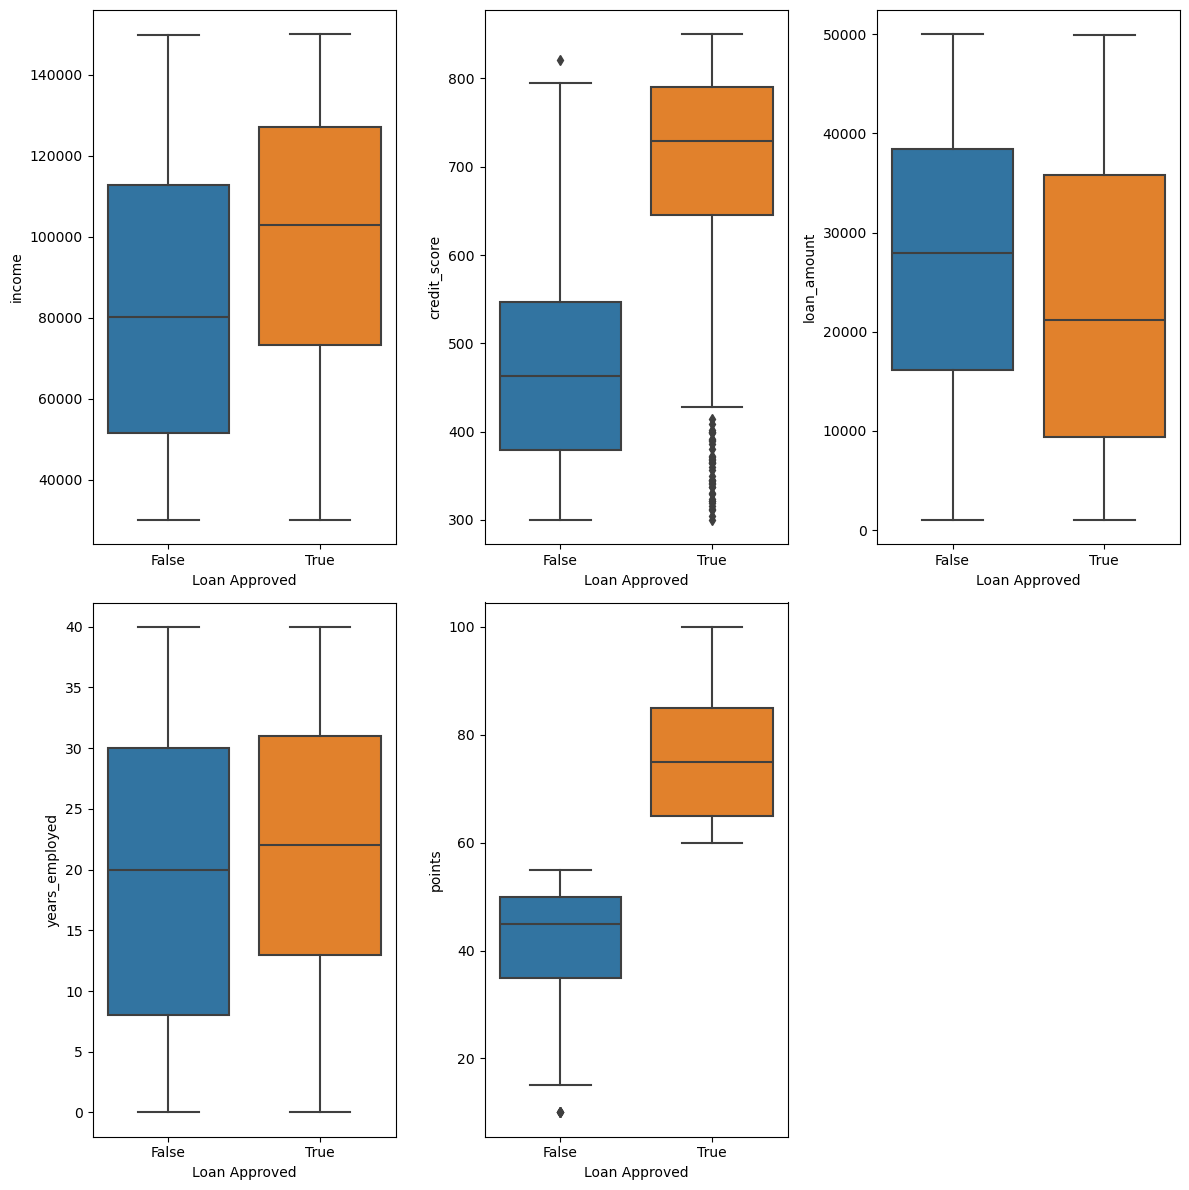

In [7]:
# check the variance of the numercial features against target classes 
cols = ['income', 'credit_score', 'loan_amount', 'years_employed', 'points']

fig, axes = plt.subplots(2, 3, figsize=(12, 12))
axes = axes.flatten() 

for i, col in enumerate(cols):
    sns.boxplot(x='loan_approved', y=col, data=df, ax=axes[i])
    axes[i].set_xlabel('Loan Approved')
    axes[i].set_ylabel(col)

if len(cols) < len(axes):
    axes[len(cols)].set_visible(False)

plt.tight_layout()
plt.show()

observations:

1. we see some clear rules for loan approval from above plots - high median income of >100k, 
high credit score of >750, lower loan amounts, high median point ~ 75

In [8]:
df2 = df.copy()

In [9]:
# standardize numercial columns 
def std_scale(col):
    mean, std = df2[col].mean(), df2[col].std()
    ser = df2[col] - mean
    ser = ser/std
    return ser 


for col in cols:
    df2[col] = std_scale(col)

In [10]:
df2.drop(["name", "city"], axis =1 ,inplace = True)

In [11]:
# assign target values of 0 (not approved) and 1 (approved) 
df2["loan_approved"] = df2["loan_approved"]*1

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# dropping points (risk factor) as training feature as it a derived value not normally available in primary banking data -
# need to build a robust model without relying on secondary features 
X = (df2.drop(["loan_approved","points"], axis=1))
y = (df2["loan_approved"])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20)

In [13]:
# check the post-split shape 
print("training data shape:", X_train.shape)
print("test data shape:",X_test.shape)

training data shape: (1600, 4)
test data shape: (400, 4)


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
# write function that will evaluate the model performance 

def eval_model(y_test, y_pred):
    prc = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Precision:", prc.round(3))
    print("Recall:", recall.round(3))
    print("F1 score:", f1.round(3))

    cm = confusion_matrix(y_test, y_pred)
    df = pd.DataFrame(cm)
    df.columns = ["Predicted Negative", "Predicted Positive"]
    df.index = ["Actual Negative", "Actual Positive"]

    print("confusion matrix:")
    return df 

In [44]:
# start with simple non-parameteric KNN classifier
# since the features have been normalized distance calc becomes sensible 
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

Training Accuracy: 0.978
Test Accuracy: 0.943


In [16]:
eval_model(y_test, y_test_pred)

Precision: 0.923
Recall: 0.957
F1 score: 0.94
confusion matrix:


,Predicted Negative,Predicted Positive
Actual Negative,198,15
Actual Positive,8,179


In [17]:
# lets evaluate knn performance by tuning the n_neighbor hyperparameter 
ns = range(2,10)
knn_res = dict()
for n in ns:
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_test, y_pred).round(3)
    knn_res.update({n:f1})

In [18]:
knn_summary = pd.DataFrame(knn_res.values(), columns = ["f1_score"])
knn_summary["n-neighbors"] = knn_res.keys()
knn_summary

,f1_score,n-neighbors
0,0.929,2
1,0.940,3
2,0.930,4
3,0.945,5
4,0.952,6
5,0.948,7
6,0.952,8
7,0.948,9


In [42]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

eval_model(y_test, y_pred)

Precision: 0.923
Recall: 0.968
F1 score: 0.945
confusion matrix:


,Predicted Negative,Predicted Positive
Actual Negative,198,15
Actual Positive,6,181


**Observations**:
1. we see that the highest model performance of **94.6%** (f1 score) lies at n=7 - this becomes our baseline accuracy
2. KNN model leads to fairly equal no. of FPs and FNs with this baseline - as seen in above confusion matrix 


In [20]:
# lets try to improve upon it with a parameteric model i.e. logistic regression 
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    solver = "lbfgs",
    max_iter = 100,
    random_state = 42

)
clf.fit(X_train,y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

Training Accuracy: 0.906
Test Accuracy: 0.900


In [21]:
eval_model(y_test, y_test_pred)

Precision: 0.889
Recall: 0.898
F1 score: 0.894
confusion matrix:


,Predicted Negative,Predicted Positive
Actual Negative,192,21
Actual Positive,19,168


In [22]:
coef = clf.coef_[0]  
features = X.columns

df_imp = pd.DataFrame({'Feature': features,'Coefficient': coef})
df_imp["coef_abs"] = abs(df_imp.Coefficient)
print(df_imp.sort_values(by = "coef_abs", ascending = False))

          Feature  Coefficient  coef_abs
1    credit_score     3.925915  3.925915
0          income     1.913119  1.913119
2     loan_amount    -1.236173  1.236173
3  years_employed     0.711441  0.711441


**Observations:**
  1. Logistic regression is actually leading to lower accuracy vs KNN i.e. both FPs and FNs increased considerably
  2. The model seems to fill equally well with training and test data so there **doesn't** seem to be any visible overfitting - regularization tuning would not yield improved performance.
  3. Comparing the model's coefficient indicates **credit score** is the **most significant feature** in determining customer's loan approval. Additionally loan amount has an **inverse relationship** with loan approval i.e. lower amounts have a higher probability of approval.

In [23]:
# ensemble modelling 
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=120,       
    max_depth=None,        
    min_samples_split=2,    
    min_samples_leaf=1,
    random_state = 42
)
rf.fit(X_train,y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

Training Accuracy: 1.000
Test Accuracy: 0.988


In [24]:
eval_model(y_test, y_test_pred)

Precision: 0.979
Recall: 0.995
F1 score: 0.987
confusion matrix:


,Predicted Negative,Predicted Positive
Actual Negative,209,4
Actual Positive,1,186


In [25]:
param_dist = {
    'n_estimators': randint(50, 300),         
    'max_depth': randint(3, 20),              
    'min_samples_split': randint(2, 10),      
    'min_samples_leaf': randint(1, 5),        
    'max_features': ['sqrt', None],   
}

rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,              
    scoring='accuracy',
    cv=5,                    
    random_state=42,
    verbose = 1
)

rs.fit(X_train, y_train)
print(rs.best_params_)

rf_final = rs.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 267}


In [26]:
y_train_pred = rf_final.predict(X_train)
y_test_pred = rf_final.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

Training Accuracy: 0.999
Test Accuracy: 0.988


In [27]:
eval_model(y_test, y_test_pred)

Precision: 0.979
Recall: 0.995
F1 score: 0.987
confusion matrix:


,Predicted Negative,Predicted Positive
Actual Negative,209,4
Actual Positive,1,186


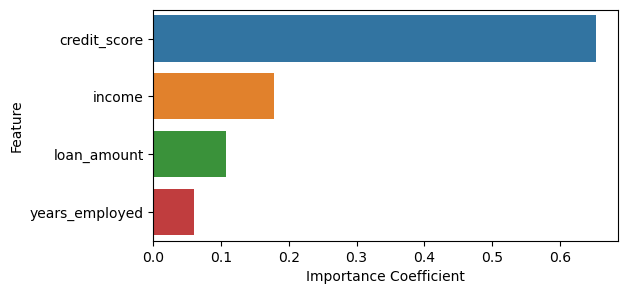

In [28]:
imp_coeff = rf_final.feature_importances_

df = pd.DataFrame({'Feature': X.columns,'Importance': imp_coeff})
df.sort_values(by = "Importance", ascending = False, inplace = True)

plt.figure(figsize=(6, 3))
sns.barplot(x='Importance', y='Feature', data=df)
plt.xlabel('Importance Coefficient')
plt.ylabel('Feature')
plt.show()

In [30]:
print(df)

          Feature  Importance
1    credit_score    0.653570
0          income    0.178670
2     loan_amount    0.107424
3  years_employed    0.060335


**Observations**
1. Random Forest leads to significant improvement in model performance - with final F1 score of **97%** and test set accuracy of **97.5%**
2. The n_estimators (no of trees) hyperparameter was increased from default 100 to 120 - led to precision improvement from 95.9% to 97%.
3. Hyperparameter tuning with randomized search led to similar performance as that observed through manual tuning - 97.5% test set accuracy.
4. As observed with logistic regression - **credit score** has significantly highest in driving loan approval decision, while **years of employment** has the least significance.

In [35]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state = 42)
xgb.fit(X_train,y_train)

y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

Training Accuracy: 1.000
Test Accuracy: 0.995


In [36]:
eval_model(y_test, y_test_pred)

Precision: 0.989
Recall: 1.0
F1 score: 0.995
confusion matrix:


,Predicted Negative,Predicted Positive
Actual Negative,211,2
Actual Positive,0,187


In [37]:
# since multiple hyperparameters can be fine-tuned to improve performance - we'll use randomizedsearchCV to find the best set
param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.5),
    'max_depth': randint(3, 20),
    'reg_alpha': uniform(0, 1),  
    'reg_lambda': uniform(0, 1)  
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,              
    scoring='accuracy',
    cv=10,                   
)

random_search.fit(X_train, y_train)

print("Ideal Parameters:")
print(random_search.best_params_)

Ideal Parameters:
{'learning_rate': 0.47874469323721347, 'max_depth': 10, 'n_estimators': 425, 'reg_alpha': 0.5101148935661022, 'reg_lambda': 0.8339276092579146}


In [40]:
# training the XGB boost model with the best set of hyperparameters 

xgb_fin = XGBClassifier(
    n_estimators=425,       
    learning_rate=0.478,    
    max_depth=10,  
    reg_alpha = 0.51,
    reg_lambda = 0.833,
    random_state = 46
)
xgb_fin.fit(X_train,y_train)

y_train_pred = xgb_fin.predict(X_train)
y_test_pred = xgb_fin.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

Training Accuracy: 1.000
Test Accuracy: 0.995


In [41]:
eval_model(y_test, y_test_pred)

Precision: 0.989
Recall: 1.0
F1 score: 0.995
confusion matrix:


,Predicted Negative,Predicted Positive
Actual Negative,211,2
Actual Positive,0,187


**Final Observations:**

1. XGBoost leads to **improvement** in test set accuracy/F1 score of **99.5%** compared to Random Forest (98.8%) - this is an increment of ~10% over the logistic regression model. 
2. However, Random Forest provides **more interpretability** in terms of model algorithm/decision-making process, along with the individual **feature importance**.
3. Hence, considering an accuracy parity of ~0.7%, deploying the trained Random Forest would allow for optimum credit decision making, along with ensuring incoming data quality and QC for significant metrics such as credit score.
4. It would be recommended to re-train the model with larger training dataset to check if the RandomForest can further match the accuracy level of XGBoost, which could further enhance accuracy of the underwriting operations. 

In [47]:
# summary of results
models = ["KNN", "Logistic Regression", "Random Forest", "XGBoost"]
accs = [ 0.948, 0.900, 0.988, 0.995]
f1 = [0.945,0.895,0.987,0.995]

res = pd.DataFrame({'model' : models, 'accurracy' : accs, 'f1-score': f1})
print(res)

                 model  accurracy  f1-score
0                  KNN      0.948     0.945
1  Logistic Regression      0.900     0.895
2        Random Forest      0.988     0.987
3              XGBoost      0.995     0.995
